# Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, http://anjos.mgi.polymtl.ca/qaplib/

[3] NUG12, http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request
import scipy.stats as stats

%matplotlib inline

In [2]:
nug = 12
QAP_INSTANCE_URL = lambda x: f'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug{x}.dat'

## Reading input data

In [3]:
def get_data(nug):
    qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL(nug))

    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    print('Problem size: %d' % n)

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Flow matrix:\n', A)

    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Distance matrix:\n', B)
    return A, B

A, B = get_data(nug)

Problem size: 12
Flow matrix:
 [[ 0.  1.  2.  3.  1.  2.  3.  4.  2.  3.  4.  5.]
 [ 1.  0.  1.  2.  2.  1.  2.  3.  3.  2.  3.  4.]
 [ 2.  1.  0.  1.  3.  2.  1.  2.  4.  3.  2.  3.]
 [ 3.  2.  1.  0.  4.  3.  2.  1.  5.  4.  3.  2.]
 [ 1.  2.  3.  4.  0.  1.  2.  3.  1.  2.  3.  4.]
 [ 2.  1.  2.  3.  1.  0.  1.  2.  2.  1.  2.  3.]
 [ 3.  2.  1.  2.  2.  1.  0.  1.  3.  2.  1.  2.]
 [ 4.  3.  2.  1.  3.  2.  1.  0.  4.  3.  2.  1.]
 [ 2.  3.  4.  5.  1.  2.  3.  4.  0.  1.  2.  3.]
 [ 3.  2.  3.  4.  2.  1.  2.  3.  1.  0.  1.  2.]
 [ 4.  3.  2.  3.  3.  2.  1.  2.  2.  1.  0.  1.]
 [ 5.  4.  3.  2.  4.  3.  2.  1.  3.  2.  1.  0.]]
Distance matrix:
 [[  0.   5.   2.   4.   1.   0.   0.   6.   2.   1.   1.   1.]
 [  5.   0.   3.   0.   2.   2.   2.   0.   4.   5.   0.   0.]
 [  2.   3.   0.   0.   0.   0.   0.   5.   5.   2.   2.   2.]
 [  4.   0.   0.   0.   5.   2.   2.  10.   0.   0.   5.   5.]
 [  1.   2.   0.   5.   0.  10.   0.   0.   0.   5.   1.   1.]
 [  0.   2.   0.   2.  

## Objective function

In [4]:
def qap_objective_function(p, A, B, n):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [5]:
p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
print(qap_objective_function(p, A, B, nug), p)

578.0 [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]


## Random Sampling

In [ ]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, nug), dtype=np.int64)
rand_costs = np.zeros(T)
for i in range(T):
    if i%10000 == 0:
        print(i)
    permutations[i, :] = np.random.permutation(nug)
    rand_costs[i] = qap_objective_function(permutations[i, :], A, B, nug)

print(time.time() - t0)

p = permutations[rand_costs.argmin(), :]
print(qap_objective_function(p, A, B, nug), p)

In [ ]:
plt.figure()
plt.plot(rand_costs)
plt.show()
plt.figure()
plt.hist(rand_costs, bins=100)
plt.show()

print(rand_costs.mean(), rand_costs.std())

## Simulated Annealing

In [10]:
def perm_dist(p, q):
    tau, p_value = stats.kendalltau(p, q)
    return (2-tau) * len(p)

def random_neighbor(p, radius, n):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

def sa(T, radius, alpha, A, B, n):
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p, A, B, n)
    costs = np.zeros(T)
    successes = np.zeros(T)
    acc_fail = np.zeros(T)
    change = np.zeros((T, 2)) - 1
    for t in range(T):
        if t%10000 == 0:
            print(t)
        q = random_neighbor(p, radius, n)
        q_cost = qap_objective_function(q, A, B, n)
        if(q_cost < p_cost):
            change[t,:] = np.array([p_cost - q_cost, perm_dist(p, q)])
            p, p_cost = q, q_cost
            successes[t] = 1
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
            acc_fail[t] = 1
        costs[t] = p_cost
    return costs, successes, acc_fail, change

def show_data(T, radius, alpha, A, B, n):
    t0 = time.time()
    costs, successes, acc_fail, change = sa(T, radius, alpha, A, B, nug)

    print(time.time() - t0, costs.min())
    plt.figure(figsize=(15,5))
    plt.plot(costs)
    plt.scatter([np.argmin(costs)], [np.min(costs)], c='red')
    plt.show()
    
    bar_data_s = successes.reshape(-1,50).sum(axis=1) 
    bar_data_a = acc_fail.reshape(-1,50).sum(axis=1) 
    
    plt.figure(figsize=(15,5))
    plt.plot(range(bar_data_s.shape[0]), bar_data_s )
    plt.plot(range(bar_data_a.shape[0]), bar_data_a )
    plt.show()
    

    plt.scatter(change[:,1], change[:,0])
    plt.show()
#     return change


Problem size: 12
Flow matrix:
 [[ 0.  1.  2.  3.  1.  2.  3.  4.  2.  3.  4.  5.]
 [ 1.  0.  1.  2.  2.  1.  2.  3.  3.  2.  3.  4.]
 [ 2.  1.  0.  1.  3.  2.  1.  2.  4.  3.  2.  3.]
 [ 3.  2.  1.  0.  4.  3.  2.  1.  5.  4.  3.  2.]
 [ 1.  2.  3.  4.  0.  1.  2.  3.  1.  2.  3.  4.]
 [ 2.  1.  2.  3.  1.  0.  1.  2.  2.  1.  2.  3.]
 [ 3.  2.  1.  2.  2.  1.  0.  1.  3.  2.  1.  2.]
 [ 4.  3.  2.  1.  3.  2.  1.  0.  4.  3.  2.  1.]
 [ 2.  3.  4.  5.  1.  2.  3.  4.  0.  1.  2.  3.]
 [ 3.  2.  3.  4.  2.  1.  2.  3.  1.  0.  1.  2.]
 [ 4.  3.  2.  3.  3.  2.  1.  2.  2.  1.  0.  1.]
 [ 5.  4.  3.  2.  4.  3.  2.  1.  3.  2.  1.  0.]]
Distance matrix:
 [[  0.   5.   2.   4.   1.   0.   0.   6.   2.   1.   1.   1.]
 [  5.   0.   3.   0.   2.   2.   2.   0.   4.   5.   0.   0.]
 [  2.   3.   0.   0.   0.   0.   0.   5.   5.   2.   2.   2.]
 [  4.   0.   0.   0.   5.   2.   2.  10.   0.   0.   5.   5.]
 [  1.   2.   0.   5.   0.  10.   0.   0.   0.   5.   1.   1.]
 [  0.   2.   0.   2.  

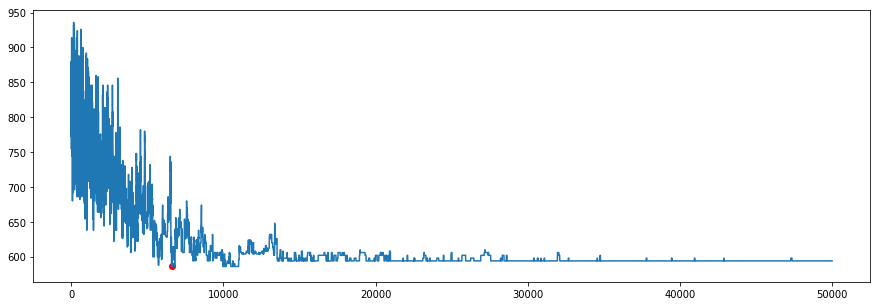

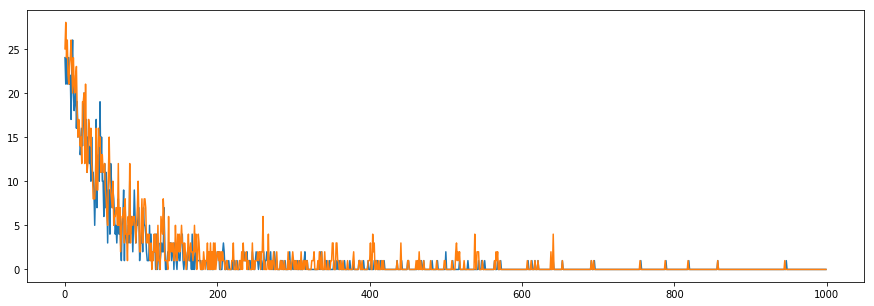

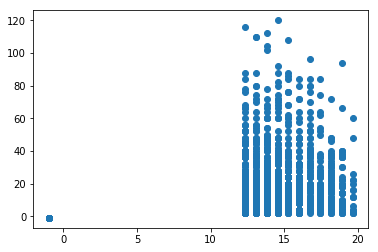

In [11]:
nug = 12
A, B = get_data(nug)

T = 50000
radius = 1
alpha = 1.0

change = show_data(T, radius, alpha, A, B, nug)

Problem size: 14
Flow matrix:
 [[ 0.  1.  2.  3.  4.  1.  2.  3.  4.  5.  2.  3.  4.  5.]
 [ 1.  0.  1.  2.  3.  2.  1.  2.  3.  4.  3.  2.  3.  4.]
 [ 2.  1.  0.  1.  2.  3.  2.  1.  2.  3.  4.  3.  2.  3.]
 [ 3.  2.  1.  0.  1.  4.  3.  2.  1.  2.  5.  4.  3.  2.]
 [ 4.  3.  2.  1.  0.  5.  4.  3.  2.  1.  6.  5.  4.  3.]
 [ 1.  2.  3.  4.  5.  0.  1.  2.  3.  4.  1.  2.  3.  4.]
 [ 2.  1.  2.  3.  4.  1.  0.  1.  2.  3.  2.  1.  2.  3.]
 [ 3.  2.  1.  2.  3.  2.  1.  0.  1.  2.  3.  2.  1.  2.]
 [ 4.  3.  2.  1.  2.  3.  2.  1.  0.  1.  4.  3.  2.  1.]
 [ 5.  4.  3.  2.  1.  4.  3.  2.  1.  0.  5.  4.  3.  2.]
 [ 2.  3.  4.  5.  6.  1.  2.  3.  4.  5.  0.  1.  2.  3.]
 [ 3.  2.  3.  4.  5.  2.  1.  2.  3.  4.  1.  0.  1.  2.]
 [ 4.  3.  2.  3.  4.  3.  2.  1.  2.  3.  2.  1.  0.  1.]
 [ 5.  4.  3.  2.  3.  4.  3.  2.  1.  2.  3.  2.  1.  0.]]
Distance matrix:
 [[  0.  10.   0.   5.   1.   0.   1.   2.   2.   2.   2.   0.   4.   0.]
 [ 10.   0.   1.   3.   2.   2.   2.   3.   2.   0.

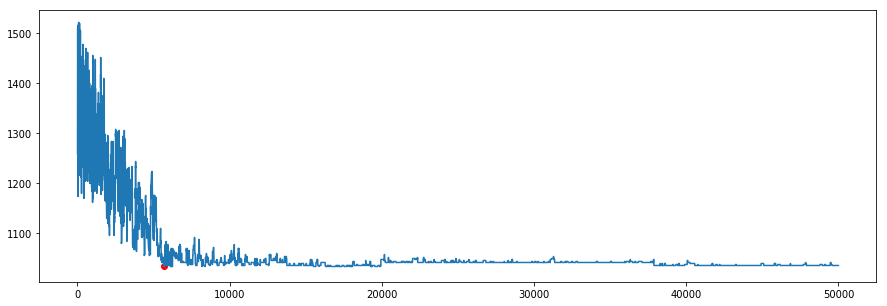

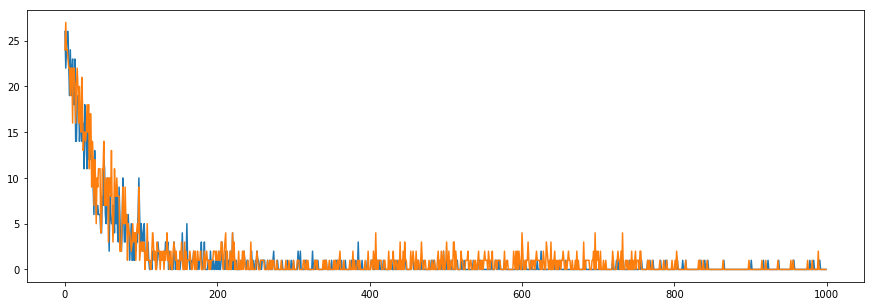

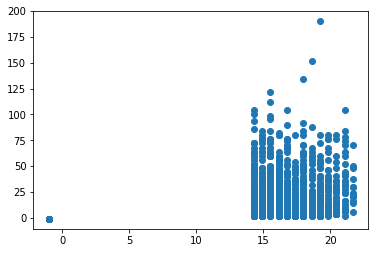

In [13]:
nug = 14
A, B = get_data(nug)

T = 50000
radius = 1
alpha = 1.0

show_data(T, radius, alpha, A, B, nug)

Problem size: 16
Flow matrix:
 [[ 0.  1.  2.  3.  4.  1.  2.  3.  4.  5.  2.  3.  4.  5.  6.  3.]
 [ 1.  0.  1.  2.  3.  2.  1.  2.  3.  4.  3.  2.  3.  4.  5.  4.]
 [ 2.  1.  0.  1.  2.  3.  2.  1.  2.  3.  4.  3.  2.  3.  4.  5.]
 [ 3.  2.  1.  0.  1.  4.  3.  2.  1.  2.  5.  4.  3.  2.  3.  6.]
 [ 4.  3.  2.  1.  0.  5.  4.  3.  2.  1.  6.  5.  4.  3.  2.  7.]
 [ 1.  2.  3.  4.  5.  0.  1.  2.  3.  4.  1.  2.  3.  4.  5.  2.]
 [ 2.  1.  2.  3.  4.  1.  0.  1.  2.  3.  2.  1.  2.  3.  4.  3.]
 [ 3.  2.  1.  2.  3.  2.  1.  0.  1.  2.  3.  2.  1.  2.  3.  4.]
 [ 4.  3.  2.  1.  2.  3.  2.  1.  0.  1.  4.  3.  2.  1.  2.  5.]
 [ 5.  4.  3.  2.  1.  4.  3.  2.  1.  0.  5.  4.  3.  2.  1.  6.]
 [ 2.  3.  4.  5.  6.  1.  2.  3.  4.  5.  0.  1.  2.  3.  4.  1.]
 [ 3.  2.  3.  4.  5.  2.  1.  2.  3.  4.  1.  0.  1.  2.  3.  2.]
 [ 4.  3.  2.  3.  4.  3.  2.  1.  2.  3.  2.  1.  0.  1.  2.  3.]
 [ 5.  4.  3.  2.  3.  4.  3.  2.  1.  2.  3.  2.  1.  0.  1.  4.]
 [ 6.  5.  4.  3.  2.  5.  4.  

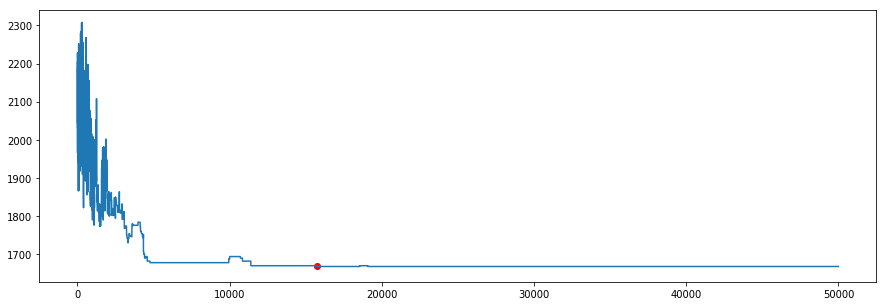

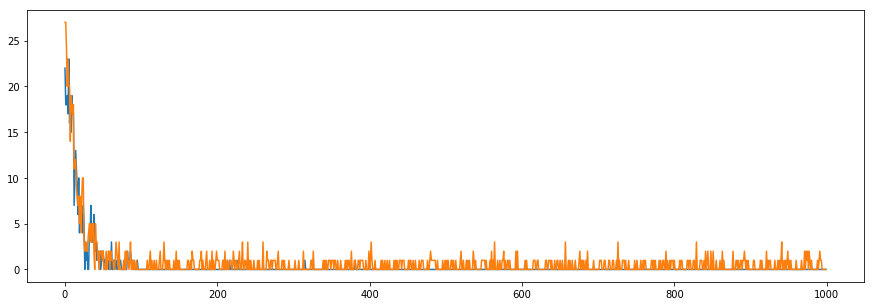

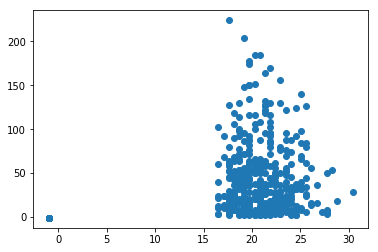

In [14]:
nug = 16
A, B = get_data("16a")

T = 50000
radius = 2
alpha = 1.5

show_data(T, radius, alpha, A, B, nug)

Problem size: 16
Flow matrix:
 [[ 0.  1.  2.  3.  1.  2.  3.  4.  2.  3.  4.  5.  3.  4.  5.  6.]
 [ 1.  0.  1.  2.  2.  1.  2.  3.  3.  2.  3.  4.  4.  3.  4.  5.]
 [ 2.  1.  0.  1.  3.  2.  1.  2.  4.  3.  2.  3.  5.  4.  3.  4.]
 [ 3.  2.  1.  0.  4.  3.  2.  1.  5.  4.  3.  2.  6.  5.  4.  3.]
 [ 1.  2.  3.  4.  0.  1.  2.  3.  1.  2.  3.  4.  2.  3.  4.  5.]
 [ 2.  1.  2.  3.  1.  0.  1.  2.  2.  1.  2.  3.  3.  2.  3.  4.]
 [ 3.  2.  1.  2.  2.  1.  0.  1.  3.  2.  1.  2.  4.  3.  2.  3.]
 [ 4.  3.  2.  1.  3.  2.  1.  0.  4.  3.  2.  1.  5.  4.  3.  2.]
 [ 2.  3.  4.  5.  1.  2.  3.  4.  0.  1.  2.  3.  1.  2.  3.  4.]
 [ 3.  2.  3.  4.  2.  1.  2.  3.  1.  0.  1.  2.  2.  1.  2.  3.]
 [ 4.  3.  2.  3.  3.  2.  1.  2.  2.  1.  0.  1.  3.  2.  1.  2.]
 [ 5.  4.  3.  2.  4.  3.  2.  1.  3.  2.  1.  0.  4.  3.  2.  1.]
 [ 3.  4.  5.  6.  2.  3.  4.  5.  1.  2.  3.  4.  0.  1.  2.  3.]
 [ 4.  3.  4.  5.  3.  2.  3.  4.  2.  1.  2.  3.  1.  0.  1.  2.]
 [ 5.  4.  3.  4.  4.  3.  2.  

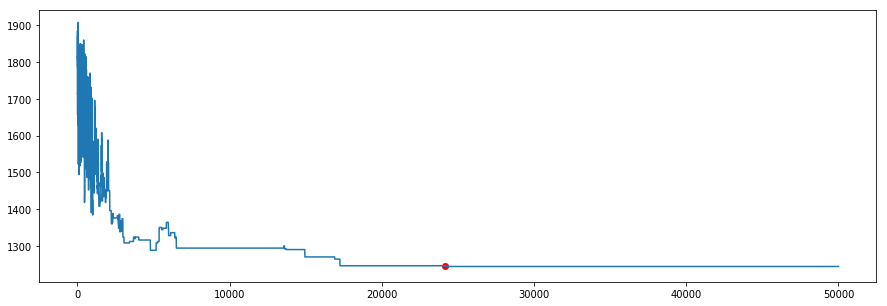

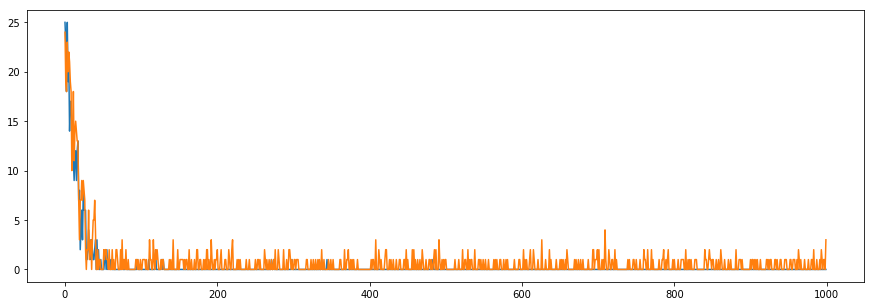

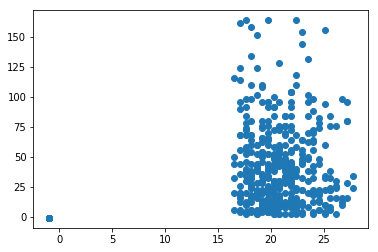

In [15]:
nug = 16
A, B = get_data("16b")

T = 50000
radius = 2
alpha = 1.5

show_data(T, radius, alpha, A, B, nug)

Problem size: 17
Flow matrix:
 [[ 0.  1.  2.  3.  4.  1.  2.  3.  4.  5.  2.  3.  4.  5.  6.  3.  4.]
 [ 1.  0.  1.  2.  3.  2.  1.  2.  3.  4.  3.  2.  3.  4.  5.  4.  3.]
 [ 2.  1.  0.  1.  2.  3.  2.  1.  2.  3.  4.  3.  2.  3.  4.  5.  4.]
 [ 3.  2.  1.  0.  1.  4.  3.  2.  1.  2.  5.  4.  3.  2.  3.  6.  5.]
 [ 4.  3.  2.  1.  0.  5.  4.  3.  2.  1.  6.  5.  4.  3.  2.  7.  6.]
 [ 1.  2.  3.  4.  5.  0.  1.  2.  3.  4.  1.  2.  3.  4.  5.  2.  3.]
 [ 2.  1.  2.  3.  4.  1.  0.  1.  2.  3.  2.  1.  2.  3.  4.  3.  2.]
 [ 3.  2.  1.  2.  3.  2.  1.  0.  1.  2.  3.  2.  1.  2.  3.  4.  3.]
 [ 4.  3.  2.  1.  2.  3.  2.  1.  0.  1.  4.  3.  2.  1.  2.  5.  4.]
 [ 5.  4.  3.  2.  1.  4.  3.  2.  1.  0.  5.  4.  3.  2.  1.  6.  5.]
 [ 2.  3.  4.  5.  6.  1.  2.  3.  4.  5.  0.  1.  2.  3.  4.  1.  2.]
 [ 3.  2.  3.  4.  5.  2.  1.  2.  3.  4.  1.  0.  1.  2.  3.  2.  1.]
 [ 4.  3.  2.  3.  4.  3.  2.  1.  2.  3.  2.  1.  0.  1.  2.  3.  2.]
 [ 5.  4.  3.  2.  3.  4.  3.  2.  1.  2.  3. 

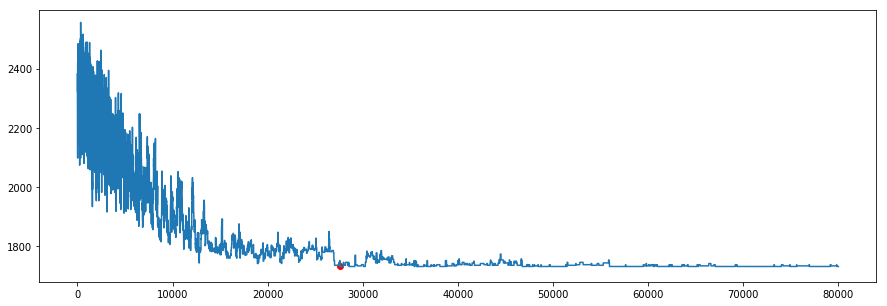

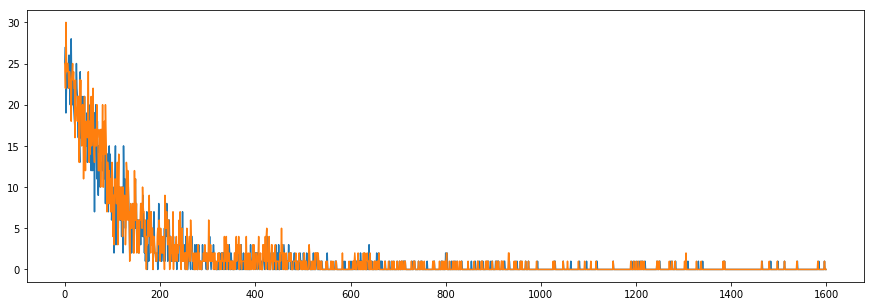

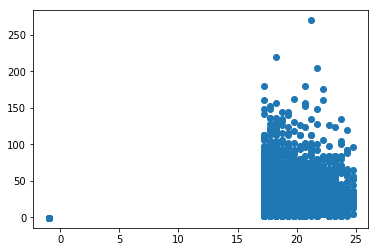

In [16]:
nug = 17
A, B = get_data(nug)

T = 80000
radius = 1
alpha = 0.5

show_data(T, radius, alpha, A, B, nug)

# b

In [24]:
tries = 1000
hist_data = np.zeros(tries)
nug = 14
A, B = get_data(nug)

T = 30000
radius = 1
alpha = 1.0
for i in range(tries):
    print("\nT = ",i)
    costs = sa(T, radius, alpha, A, B, nug)
    hist_data[i] = np.min(costs)



Problem size: 14
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.  1.  0.  2.  5.]
 [ 1.  2.  2.  1.  0.  3.  5.  5.  5.  1.  0.  3.  0.  5.]
 [ 0.  2.  0.  1.  3.  0.

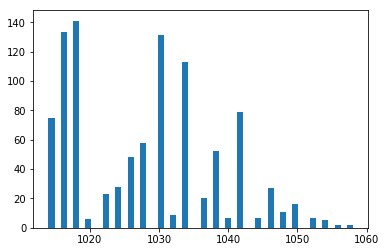

In [29]:
plt.hist(hist_data, bins=50)
plt.show()

# d